# Trainig and evaluating the UNet model on brain MRI images

## Importing the necessary libraries

In [10]:
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
# importing from the local python files
from data_pipeline import BrainDataset
from losses import DiceLoss, BCEDiceLoss
from models import UNet
from utils import train_one_epoch, evaluate, export2onnx

# Building and Training UNet

In [11]:
model = UNet(in_channels=3)

In [12]:
class RescaleMask:
    def __call__(self, img):
        return img.clamp(min=0, max=1)


mask_transform = transforms.Compose([
    transforms.ToTensor(),
    RescaleMask()
])

train_loader = BrainDataset(True, transforms.ToTensor(), mask_transform)
train_loader = DataLoader(train_loader, batch_size=64, shuffle=True)
test_loader = BrainDataset(False, transforms.ToTensor(), mask_transform)
test_loader = DataLoader(test_loader, batch_size=64, shuffle=False)

In [13]:
loss = BCEDiceLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [14]:
min_test_loss = 1
writer = SummaryWriter()
for epoch in range(30):
    print(f'---------Epoch {epoch + 1}---------')
    print(f'Current learning rate: {scheduler.get_last_lr()[0]}')
    train_loss = train_one_epoch(model, loss, optimizer, train_loader)
    writer.add_scalar('Loss/Train', train_loss, epoch)
    test_loss, test_miou, test_sensitivity, test_specificity, j_index = evaluate(model, loss, test_loader)
    writer.add_scalar('Loss/Test', test_loss, epoch)
    writer.add_scalar('mIoU/Test', test_miou, epoch)
    writer.add_scalar('Sensitivity/Test', test_sensitivity, epoch)
    writer.add_scalar('Specificity/Test', test_specificity, epoch)
    writer.add_scalar("Youden's J Index/Test", j_index, epoch)
    if test_loss < min_test_loss:
        min_test_loss = test_loss
        torch.save(model, 'models/model.pth')
    if scheduler.get_last_lr()[0] > 0.0001:
        scheduler.step()

---------Epoch 1---------
Current learning rate: 0.01
loss: 1.76305 [64/3205]
loss: 0.96385 [1664/3205]
loss: 0.89226 [3205/3205]
Test Metrics: 
    Loss: 0.97048 mIoU: 0.63214 Sensitivity: 0.63214 Specificity: 1.01186 Youden's J Index: 0.64400
---------Epoch 2---------
Current learning rate: 0.01
loss: 0.92595 [64/3205]
loss: 0.89546 [1664/3205]
loss: 0.95228 [3205/3205]
Test Metrics: 
    Loss: 1.02412 mIoU: 0.63214 Sensitivity: 0.63214 Specificity: 1.01186 Youden's J Index: 0.64400
---------Epoch 3---------
Current learning rate: 0.01
loss: 0.85650 [64/3205]
loss: 0.99912 [1664/3205]
loss: 0.63948 [3205/3205]
Test Metrics: 
    Loss: 0.94867 mIoU: 0.63214 Sensitivity: 0.63214 Specificity: 1.01186 Youden's J Index: 0.64400
---------Epoch 4---------
Current learning rate: 0.01
loss: 0.81641 [64/3205]
loss: 0.90708 [1664/3205]
loss: 0.92860 [3205/3205]
Test Metrics: 
    Loss: 0.92248 mIoU: 0.63214 Sensitivity: 0.63214 Specificity: 1.01186 Youden's J Index: 0.64400
---------Epoch 5----

# Confirmation of the train result

In [15]:
img = cv2.imread('dataset/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif')
transform = transforms.ToTensor()
img = transform(img)
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 256, 256])

In [16]:
model = torch.load('models/model.pth')
model.eval()
device = torch.device('cuda')
pred = (model(img.to(device)) > 0.5).float()
print(pred.shape)
pred = pred.squeeze(0)
print(pred.shape)
pred = pred.squeeze()
print(pred.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([256, 256])


0.0 1.0


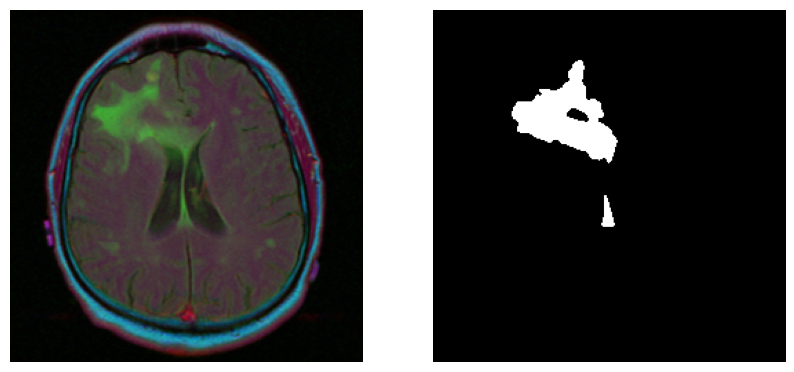

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
pred = pred.detach().cpu().numpy()
print(pred.min(), pred.max())
img = cv2.imread('dataset/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif')
ax1.imshow(img)
ax1.axis('off')
ax2.imshow(pred, cmap='gray')
ax2.axis('off')
plt.show()

In [18]:
export2onnx(
    model=model,
    model_name='models/unet.onnx',
    input_shape=(1, 3, 256, 256)
)